Shape: (148670, 34)
      ID  year loan_limit             Gender approv_in_adv loan_type  \
0  24890  2019         cf  Sex Not Available         nopre     type1   
1  24891  2019         cf               Male         nopre     type2   
2  24892  2019         cf               Male           pre     type1   
3  24893  2019         cf               Male         nopre     type1   
4  24894  2019         cf              Joint           pre     type1   

  loan_purpose Credit_Worthiness open_credit business_or_commercial  ...  \
0           p1                l1        nopc                  nob/c  ...   
1           p1                l1        nopc                    b/c  ...   
2           p1                l1        nopc                  nob/c  ...   
3           p4                l1        nopc                  nob/c  ...   
4           p1                l1        nopc                  nob/c  ...   

   credit_type  Credit_Score  co-applicant_credit_type    age  \
0          EXP           

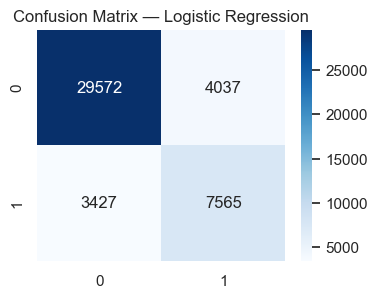


Training Model: Naive Bayes
Train Accuracy: 0.748
Test Accuracy: 0.8763
Training Time: 0.210132 sec
Prediction Time: 0.047994 sec


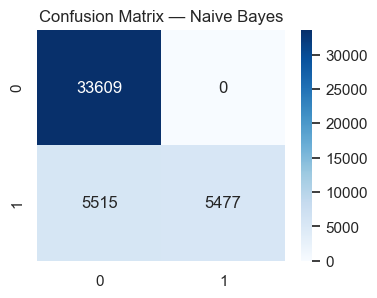


Training Model: SVM
Train Accuracy: 0.61
Test Accuracy: 0.4136
Training Time: 33.547137 sec
Prediction Time: 0.708325 sec


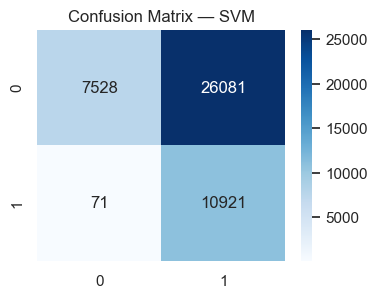


Training Model: Decision Tree
Train Accuracy: 1.0
Test Accuracy: 1.0
Training Time: 0.822513 sec
Prediction Time: 0.00947 sec


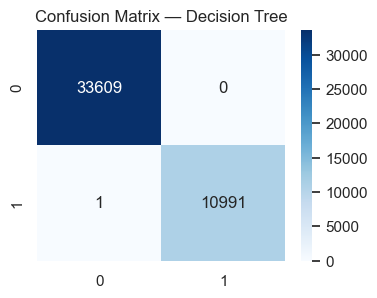


Training Model: Random Forest
Train Accuracy: 1.0
Test Accuracy: 1.0
Training Time: 25.130652 sec
Prediction Time: 0.642075 sec


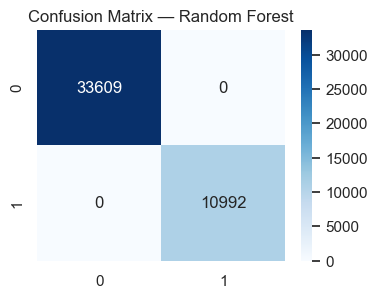


Training Model: XGBoost
Train Accuracy: 1.0
Test Accuracy: 1.0
Training Time: 1.445972 sec
Prediction Time: 0.050506 sec


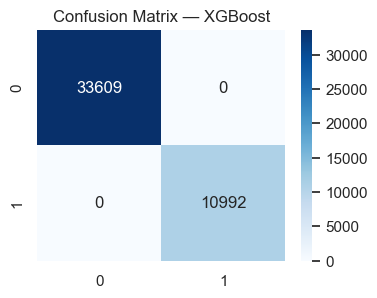


Training Model: KNN
Train Accuracy: 0.9607
Test Accuracy: 0.9023
Training Time: 0.15876 sec
Prediction Time: 17.848279 sec


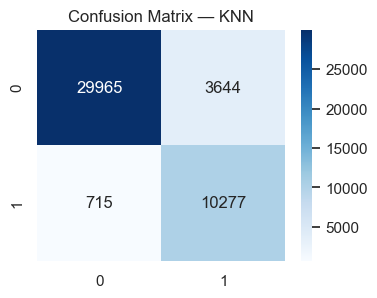

In [1]:

import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_auc_score, roc_curve)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# SMOTE
from imblearn.over_sampling import SMOTE


#  LOAD DATASET


df = pd.read_csv("data/Loan_default.csv")                 
print("Shape:", df.shape)
print(df.head())

TARGET = "Status"

print("\nTarget distribution before cleaning:")
print(df[TARGET].value_counts())


#  HANDLE MISSING VALUES

num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

# Remove target from categorical
if TARGET in cat_cols:
    cat_cols.remove(TARGET)

for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print("\nMissing values after cleaning:")
print(df.isnull().sum())


#  ENCODING

le = LabelEncoder()
df[TARGET] = le.fit_transform(df[TARGET])

df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print("\nShape after encoding:", df.shape)

#  SPLIT DATA
# 
X = df.drop(columns=[TARGET])
y = df[TARGET]

# Fix column names for XGBoost
X.columns = (
    X.columns
    .str.replace('[', '', regex=False)
    .str.replace(']', '', regex=False)
    .str.replace('<', '', regex=False)
    .str.replace('>', '', regex=False)
    .str.replace('/', '_', regex=False)
    .str.replace(' ', '_', regex=False)
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("\nTrain/Test Split Done:")
print("Train:", X_train.shape, "| Test:", X_test.shape)


#  SCALING

scaler = StandardScaler()
numeric_cols = X_train.select_dtypes(include=[np.number]).columns

X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# =============================
#  APPLY SMOTE
# =============================
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print("\nBefore SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", y_train_sm.value_counts().to_dict())

# =============================
#  MODEL SETUP
# =============================
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight='balanced'),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(kernel='linear', max_iter=500, probability=True, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight='balanced'),
    "XGBoost": xgb.XGBClassifier(eval_metric='logloss', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}


results = []
trained_models = {}

for name, model in models.items():
    print("\n===============================")
    print(f"Training Model: {name}")
    print("===============================")

    # ------- TRAINING TIME -------
    start_train = time.time()
    model.fit(X_train_sm, y_train_sm)
    end_train = time.time()
    train_time = end_train - start_train

    trained_models[name] = model

    # ------- TRAIN ACCURACY -------
    y_train_pred = model.predict(X_train_sm)
    train_accuracy = accuracy_score(y_train_sm, y_train_pred)

    # ------- PREDICTION TIME -------
    start_pred = time.time()
    y_pred = model.predict(X_test)
    end_pred = time.time()
    infer_time = end_pred - start_pred

    # ------- TEST METRICS -------
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
    except:
        y_proba = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    # Save results
    results.append([
        name, acc*100, prec*100, rec*100, f1*100,
        auc*100 if auc else None,
        train_accuracy*100, train_time, infer_time
    ])

    print("Train Accuracy:", round(train_accuracy, 4))
    print("Test Accuracy:", round(acc, 4))
    print("Training Time:", round(train_time, 6), "sec")
    print("Prediction Time:", round(infer_time, 6), "sec")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
    plt.title(f"Confusion Matrix — {name}")
    plt.show()


In [2]:
results_df = pd.DataFrame(results, columns=[
    "Model", "Accuracy", "Precision", "Recall", "F1", "ROC-AUC",
    "Train Accuracy", "Training Time (sec)", "Prediction Time (sec)"
])

print("\n===== FINAL RESULTS =====\n")
print(results_df)


===== FINAL RESULTS =====

                 Model    Accuracy   Precision      Recall          F1  \
0  Logistic Regression   83.264949   65.204275   68.822780   66.964681   
1          Naive Bayes   87.634806  100.000000   49.827147   66.512842   
2                  SVM   41.364543   29.514621   99.354076   45.509855   
3        Decision Tree   99.997758  100.000000   99.990902   99.995451   
4        Random Forest  100.000000  100.000000  100.000000  100.000000   
5              XGBoost  100.000000  100.000000  100.000000  100.000000   
6                  KNN   90.226677   73.823720   93.495269   82.503111   

      ROC-AUC  Train Accuracy  Training Time (sec)  Prediction Time (sec)  
0   85.158477       81.440157             2.556391               0.016577  
1   99.995446       74.795338             0.210132               0.047994  
2   62.359567       60.998189            33.547137               0.708325  
3   99.995451      100.000000             0.822513               0.009470  

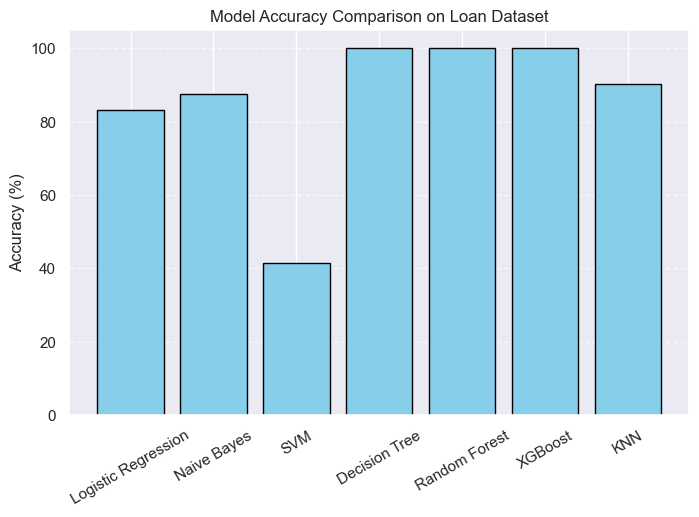

In [3]:
plt.figure(figsize=(8,5))
plt.bar(results_df["Model"], results_df["Accuracy"], color="skyblue", edgecolor="black")
plt.title("Model Accuracy Comparison on Loan Dataset")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

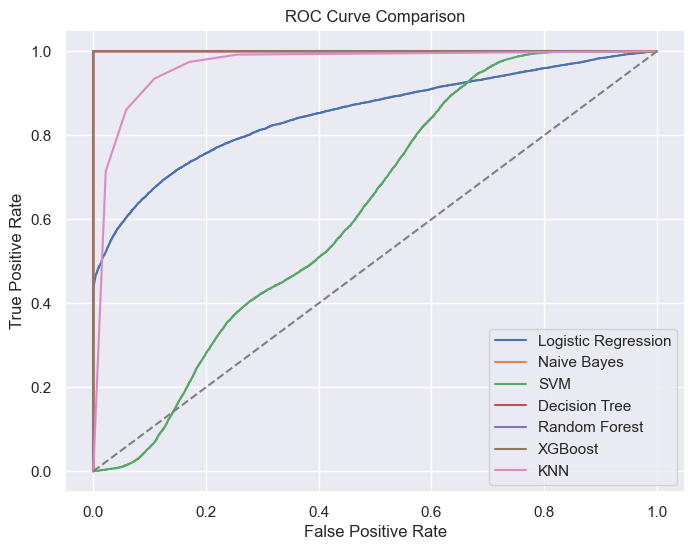

In [4]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(8,6))

for name, model in trained_models.items():
    try:
        y_proba = model.predict_proba(X_test)[:,1]
    except:
        continue

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=name)

plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

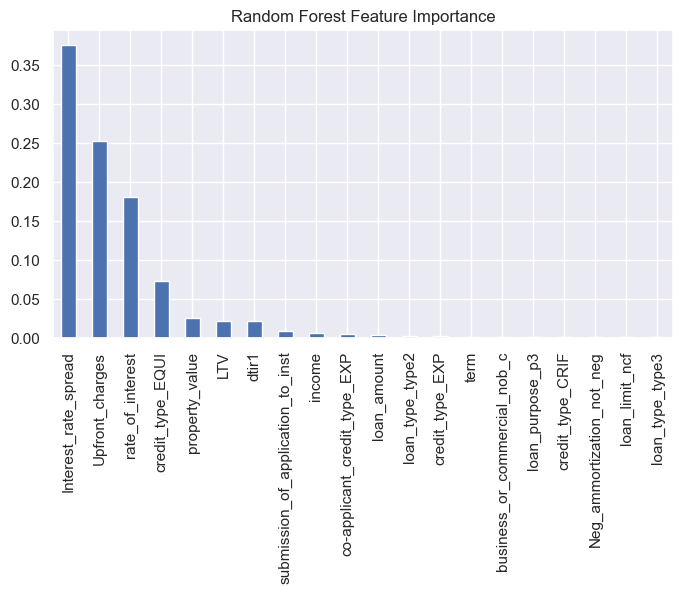

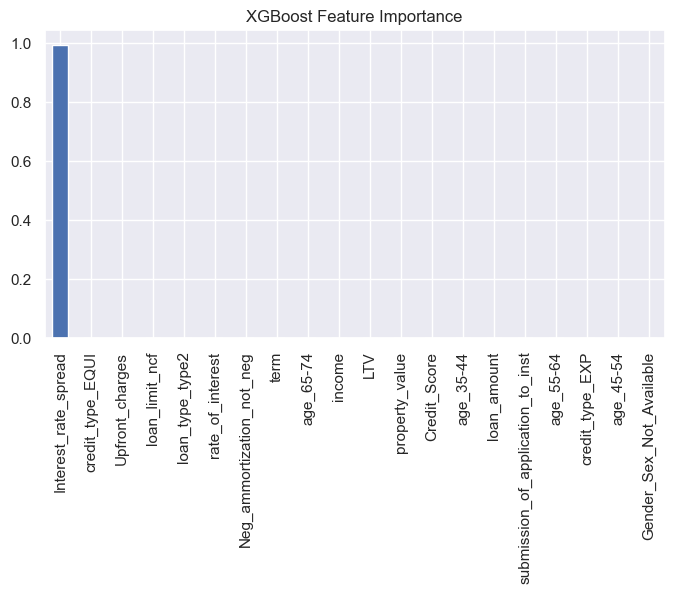

In [5]:

def plot_importances(model, title):
    if hasattr(model, "feature_importances_"):
        imp = pd.Series(model.feature_importances_, index=X.columns)
        imp.sort_values(ascending=False).head(20).plot(kind='bar', figsize=(8,4))
        plt.title(title)
        plt.show()

plot_importances(trained_models["Random Forest"], "Random Forest Feature Importance")
plot_importances(trained_models["XGBoost"], "XGBoost Feature Importance")